<a href="https://colab.research.google.com/github/benjaminsw/MResDissertation/blob/main/5_architecture_DarkCovidNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### install additional libraries

In [ ]:
!pip install split_folders

### check resources

In [ ]:
# export
import torch

def is_cuda_available():
    assert (
        torch.cuda.is_available()
    ), "PyTorch could not find cuda, you may have been suspended which breaks cuda support in the     environment."
    print("PyTorch found cuda.")
    return True

is_cuda_available()

PyTorch found cuda.


True

In [ ]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
Tesla P100-PCIE-16GB


In [ ]:
#Assign cuda GPU located at location '0' to a variable
torch.device('cuda:0')

device(type='cuda', index=0)

In [ ]:
# check RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('You are **NOT** using a high-RAM runtime')
else:
  print('You are **using** a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are **using** a high-RAM runtime!


### get data and rename directory

In [ ]:
!git clone https://github.com/benjaminsw/COVID-19.git

Cloning into 'COVID-19'...
remote: Enumerating objects: 1237, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 1237 (delta 27), reused 4 (delta 1), pack-reused 1156
Receiving objects: 100% (1237/1237), 400.89 MiB | 26.50 MiB/s, done.
Resolving deltas: 100% (29/29), done.
Checking out files: 100% (1129/1129), done.


In [ ]:
# rename folder to remove white space
!mv 'COVID-19/X-Ray Image DataSet' 'COVID-19/X-Ray_Image_DataSet'

# list files in directory
!ls COVID-19/X-Ray_Image_DataSet

Covid-19  No_findings  Pneumonia


### import libary 

In [ ]:
import splitfolders
from fastai.vision import *
import fastai
import warnings
warnings.filterwarnings('ignore')

In [ ]:
splitfolders.ratio('/content/COVID-19/X-Ray_Image_DataSet', output='output', seed=2020, ratio=(.6, 0.2,0.2)) 

Copying files: 1125 files [00:00, 1303.37 files/s]


In [ ]:
path = Path('/content/output')

### Training a neural net in fast.ai

There are 2 concepts at a high level:

DataBunch: A general fastai concept for your data, and from there, there are subclasses for particular applications like ImageDataBunch

Learner: A general concept for things that can learn to fit a model. From that, there are various subclasses to make things easier in particular, there is a convnet learner (something that will create a convolutional neural network for you).

In [ ]:
np.random.seed(41)
data = ImageDataBunch.from_folder(path, train = 'train', valid = 'val', test = 'test',
        ds_tfms=get_transforms(), size=(256,256), bs=32, num_workers=4).normalize()
data

ImageDataBunch;

Train: LabelList (675 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Pneumonia,Pneumonia,Pneumonia,Pneumonia,Pneumonia
Path: /content/output;

Valid: LabelList (225 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Pneumonia,Pneumonia,Pneumonia,Pneumonia,Pneumonia
Path: /content/output;

Test: LabelList (225 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: /content/output

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds), len(data.test_ds)

(['Covid-19', 'No_findings', 'Pneumonia'], 3, 675, 225, 225)

In [ ]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))
print("Number of examples in testset:", len(data.test_ds))

Number of examples in training: 675
Number of examples in validation: 225
Number of examples in testset: 225


In [ ]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

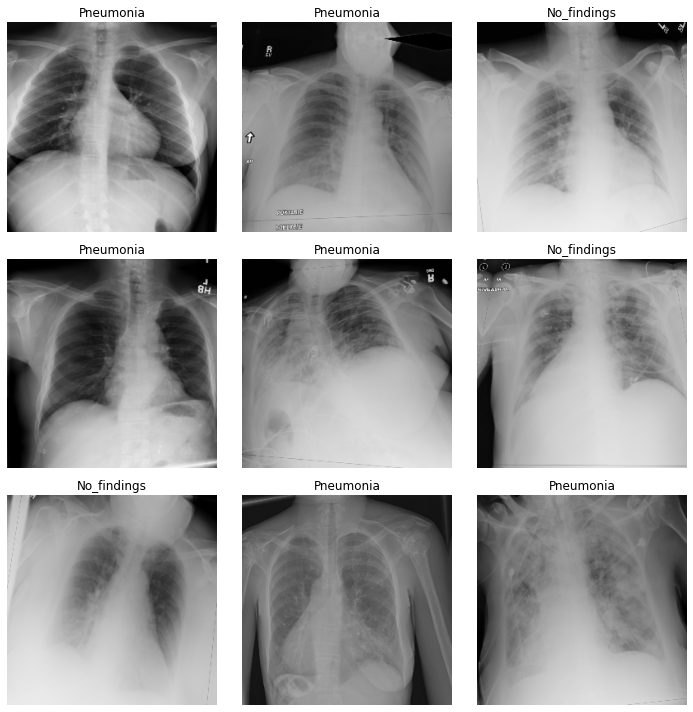

In [ ]:
data.show_batch(rows=3, figsize=(10,10))

### available models in fastAI

In [ ]:
# dir(fastai.vision.models)

### DarkCovidNet (modified Darknet model)

activation functions: https://pytorch.org/docs/stable/nn.html

In [ ]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.Softplus()  
    )

In [ ]:
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )

In [ ]:
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

In [ ]:
model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    conv_layer(256, 3),
    Flatten(),
    nn.Linear(507, 3)
)

In [ ]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=[accuracy, error_rate])

In [ ]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
Softplus             [8, 256, 256]        0          False     
______________________________________________________________________
MaxPool2d            [8, 128, 128]        0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
Softplus             [16, 128, 128]       0          False     
___________________________________________________